# Treinando um classificador de imagem



In [2]:
# Carregando as bibliotecas que serão usadas

import torch # Usado para construir e treinar redes neurais.
import torch.nn as nn
import torch.optim as optim
import torchvision # Possui utilitários para processamento de dados, como datasets e modelos pré-treinados.
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt # Para plotar gráficos e visualizar resultados.
import numpy as np
from tqdm import tqdm # biblioteca para mostrar progresso de looping

In [3]:
# Verifica se uma GPU está disponível
if torch.cuda.is_available():
    device = torch.device("cuda")  # Usar GPU
    print("Usando GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Usar CPU
    print("Usando CPU")

Usando CPU


In [4]:
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
batch_size_train = 500
batch_size_test = 100

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #expande e realiza um corte na imagem
    transforms.RandomHorizontalFlip(), # Realiza um flip horizontal aleatório na imagem (espelhamento em torno do eixo vertical).
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

transform_test = transforms.Compose([
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

# carregando os dados de treino
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size_train, shuffle=True, num_workers=2)

# carregando os dados de teste
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size_test, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Explicação:

São usados parametros diferentes no transforms, pois o **treino** do modelo tem a necessidade de ver variações diferentes das imagens para não criar um hábito de vício durante o treinamento, já o **teste**, recebe parametros iguais para estabilizar e dar precisão ao modelo.

Primeiras 16 imagens


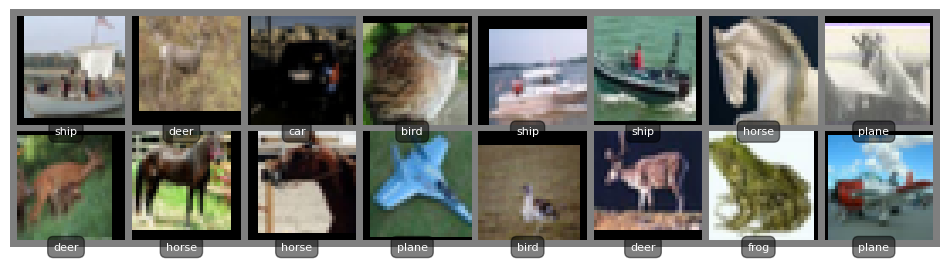

In [5]:
def mostrar_imagens_com_rotulos(imgs, labels):
    imgs = (imgs * 0.5) + 0.5  # Desnormalizar (reverter a normalização)
    npimg = imgs.numpy()  # converter tensor para numpy

    plt.figure(figsize=(12, 12))  # amplia as imagens
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpor para formato HWC
    plt.axis('off')  # tira as marcações de eixos

    # Obter o número de imagens por linha e altura de cada imagem
    num_imgs = len(labels)
    img_size = 32  # Tamanho de cada imagem (CIFAR-10 tem 32x32 pixels)
    padding = 2  # Padding utilizado pelo make_grid para separar as imagens

    for i in range(num_imgs):
        # Posição do texto na imagem, considerando a faixa cinza
        plt.text((i % 8) * (img_size + padding) + img_size // 2,
                 (i // 8) * (img_size + padding) + img_size + 5,  # Posiciona um pouco acima da parte inferior
                 classes[labels[i]], color='white', fontsize=8, ha='center', va='bottom',
                 bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.5'))

    plt.show()

# Obtendo imagens de treinamento aleatórias
dataiter = iter(trainloader)  # iterador para o DataLoader
images, labels = next(dataiter)  # obter um batch de imagens e rótulos

# Definir as classes do CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Selecionando as primeiras 16 imagens
images_16 = images[:16]
labels_16 = labels[:16]

# Mostrar imagens com rótulos diretamente
print('Primeiras 16 imagens')
mostrar_imagens_com_rotulos(torchvision.utils.make_grid(images_16, nrow=8), labels_16)



# Treinamento de uma rede do zero

In [6]:
model_zero = torchvision.models.resnet18(weights=None)  # Treinamento do zero
model_zero.fc = nn.Linear(model_zero.fc.in_features, 10)  # Modifica a última camada para 10 classes

# Uso de uma rede pré-treinada sem fine-tuning

In [7]:
model_no_ft = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)  # Rede pré-treinada

for param in model_no_ft.parameters():
    param.requires_grad = False  # Congelar as camadas

model_no_ft.fc = nn.Linear(model_no_ft.fc.in_features, 10)  # Modifica a última camada para 10 classes

# Fine-tuning de uma rede pré-treinada

In [8]:
# Não congela as camadas, permitindo o fine-tuning de toda a rede
model_on_ft = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) #ResNet18 já pré-treinada
model_on_ft.fc = nn.Linear(model_on_ft.fc.in_features, 10) # Modifica a última camada para 10 classes (CIFAR-10)

In [9]:
criterion = nn.CrossEntropyLoss() # loss funciton

In [10]:
optimizer_zero = optim.Adam(model_zero.parameters(), lr=0.001) # modelo otimizador

In [11]:
optimizer_no_ft = optim.Adam(model_no_ft.parameters(), lr=0.001) # modelo otimizador

In [12]:
optimizer_on_ft = optim.Adam(model_on_ft.parameters(), lr=0.001) # modelo otimizador

In [13]:
def treino_modelo(modelo, otimizador, epocas):
  epochs = epocas # número de épocas (quantas vezes o modelo verá o conjunto de treino)

  train_losses = []
  for epoch in range(epochs):
    modelo.train() # coloca o modelo em modo de treinamento
    running_loss = 0.0

    for inputs, labels in tqdm(trainloader):

      otimizador.zero_grad() # zera os gradientes acumulados
      outputs = modelo(inputs) # foward pass: obtem as predições
      loss = criterion(outputs, labels) # calcula a perda
      loss.backward() # backward pass: calcula os gradientes
      otimizador.step() # atualiza os pesos

      running_loss += loss.item() # acumula a perda

    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1} / {epochs}], Loss: {epoch_loss:.4f}')

  return train_losses

Explicação:
* num_epochs: Número de épocas define quantas vezes o modelo verá todo o dataset de treinamento.
* model.train(): Coloca o modelo no modo de treinamento, permitindo que os gradientes sejam calculados e os pesos atualizados.
* optimizer.zero_grad(): Zera os gradientes antes de cada iteração, para que eles não sejam acumulados.
* outputs = model(inputs): Passa as imagens através da rede para gerar predições.
* loss.backward(): Calcula os gradientes da função de perda em relação aos pesos.
* optimizer.step(): Atualiza os pesos da rede com base nos gradientes calculados.

# Treino rede do zero

In [23]:
train_losses_zero = treino_modelo(model_zero, optimizer_zero, 10)

100%|██████████| 100/100 [04:58<00:00,  2.99s/it]


Epoch [1 / 10], Loss: 0.8442


100%|██████████| 100/100 [04:54<00:00,  2.95s/it]


Epoch [2 / 10], Loss: 0.7895


100%|██████████| 100/100 [04:50<00:00,  2.90s/it]


Epoch [3 / 10], Loss: 0.7512


100%|██████████| 100/100 [04:48<00:00,  2.89s/it]


Epoch [4 / 10], Loss: 0.7095


100%|██████████| 100/100 [04:49<00:00,  2.90s/it]


Epoch [5 / 10], Loss: 0.6882


100%|██████████| 100/100 [04:48<00:00,  2.89s/it]


Epoch [6 / 10], Loss: 0.6490


100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


Epoch [7 / 10], Loss: 0.6299


100%|██████████| 100/100 [04:56<00:00,  2.96s/it]


Epoch [8 / 10], Loss: 0.5995


100%|██████████| 100/100 [04:52<00:00,  2.92s/it]


Epoch [9 / 10], Loss: 0.5741


100%|██████████| 100/100 [04:49<00:00,  2.89s/it]

Epoch [10 / 10], Loss: 0.5679


# Treino rede sem fine_turning

In [24]:
train_losses_no_ft = treino_modelo(model_no_ft, optimizer_no_ft, 40)

100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch [1 / 40], Loss: 1.6379


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [2 / 40], Loss: 1.6460


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch [3 / 40], Loss: 1.6399


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch [4 / 40], Loss: 1.6409


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch [5 / 40], Loss: 1.6411


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [6 / 40], Loss: 1.6354


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [7 / 40], Loss: 1.6439


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [8 / 40], Loss: 1.6356


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [9 / 40], Loss: 1.6378


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


Epoch [10 / 40], Loss: 1.6441


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [11 / 40], Loss: 1.6373


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [12 / 40], Loss: 1.6387


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


Epoch [13 / 40], Loss: 1.6388


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [14 / 40], Loss: 1.6435


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [15 / 40], Loss: 1.6417


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [16 / 40], Loss: 1.6388


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch [17 / 40], Loss: 1.6440


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [18 / 40], Loss: 1.6352


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [19 / 40], Loss: 1.6359


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Epoch [20 / 40], Loss: 1.6407


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Epoch [21 / 40], Loss: 1.6392


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch [22 / 40], Loss: 1.6342


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch [23 / 40], Loss: 1.6404


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch [24 / 40], Loss: 1.6323


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch [25 / 40], Loss: 1.6414


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Epoch [26 / 40], Loss: 1.6383


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch [27 / 40], Loss: 1.6442


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch [28 / 40], Loss: 1.6368


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch [29 / 40], Loss: 1.6324


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Epoch [30 / 40], Loss: 1.6373


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch [31 / 40], Loss: 1.6363


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch [32 / 40], Loss: 1.6395


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch [33 / 40], Loss: 1.6360


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Epoch [34 / 40], Loss: 1.6434


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [35 / 40], Loss: 1.6325


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [36 / 40], Loss: 1.6438


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Epoch [37 / 40], Loss: 1.6420


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Epoch [38 / 40], Loss: 1.6410


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Epoch [39 / 40], Loss: 1.6353


100%|██████████| 100/100 [00:43<00:00,  2.33it/s]

Epoch [40 / 40], Loss: 1.6331


# Treino rede com fine-turning

In [25]:
train_losses_on_ft = treino_modelo(model_on_ft, optimizer_on_ft, 10)

100%|██████████| 100/100 [04:46<00:00,  2.86s/it]


Epoch [1 / 10], Loss: 0.4481


100%|██████████| 100/100 [04:45<00:00,  2.86s/it]


Epoch [2 / 10], Loss: 0.4287


100%|██████████| 100/100 [04:45<00:00,  2.86s/it]


Epoch [3 / 10], Loss: 0.4010


100%|██████████| 100/100 [05:13<00:00,  3.13s/it]


Epoch [4 / 10], Loss: 0.3790


100%|██████████| 100/100 [04:54<00:00,  2.95s/it]


Epoch [5 / 10], Loss: 0.3687


100%|██████████| 100/100 [04:50<00:00,  2.91s/it]


Epoch [6 / 10], Loss: 0.3474


100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


Epoch [7 / 10], Loss: 0.3345


100%|██████████| 100/100 [04:48<00:00,  2.88s/it]


Epoch [8 / 10], Loss: 0.3234


100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


Epoch [9 / 10], Loss: 0.3044


100%|██████████| 100/100 [04:52<00:00,  2.93s/it]

Epoch [10 / 10], Loss: 0.2937


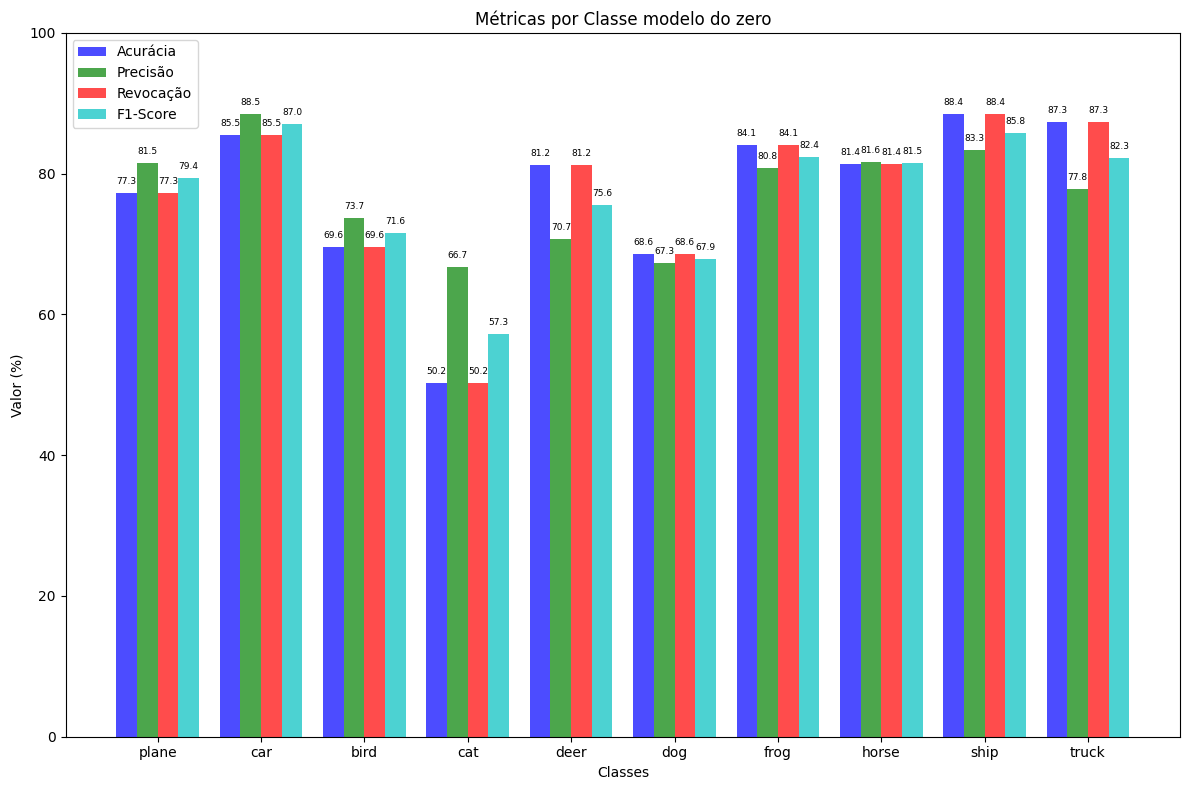

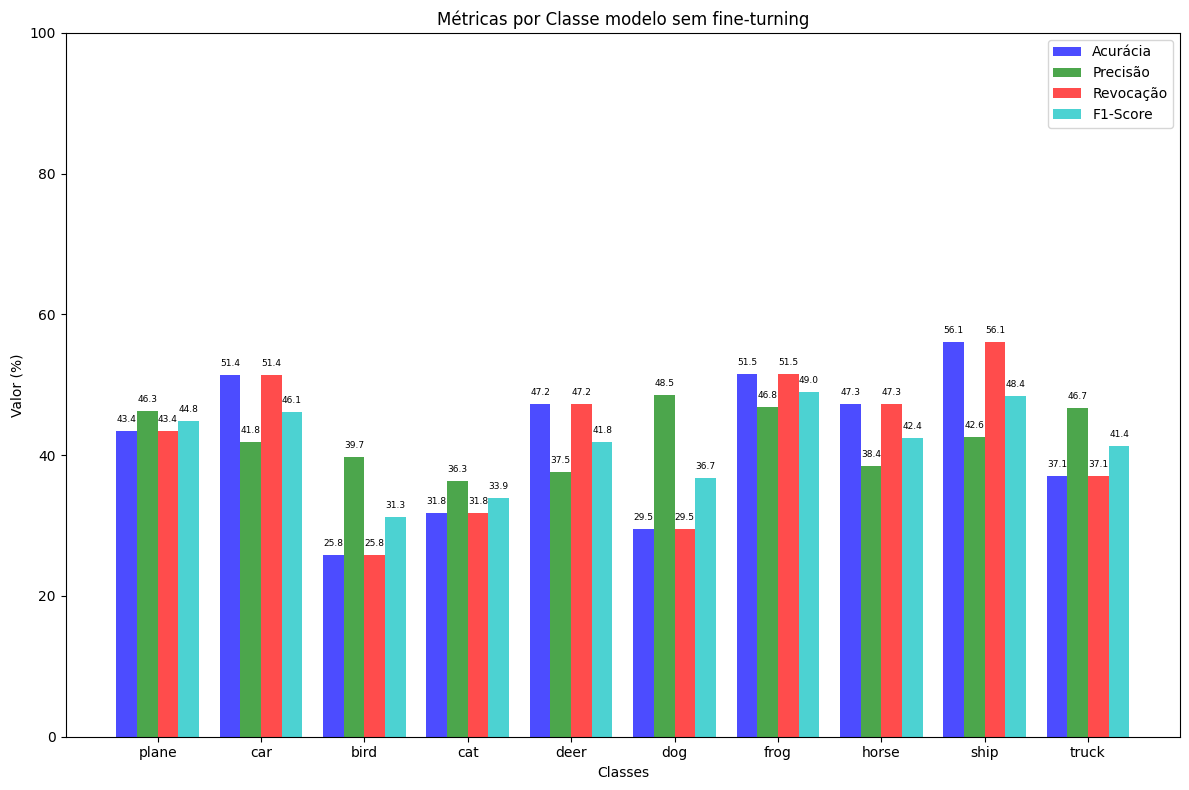

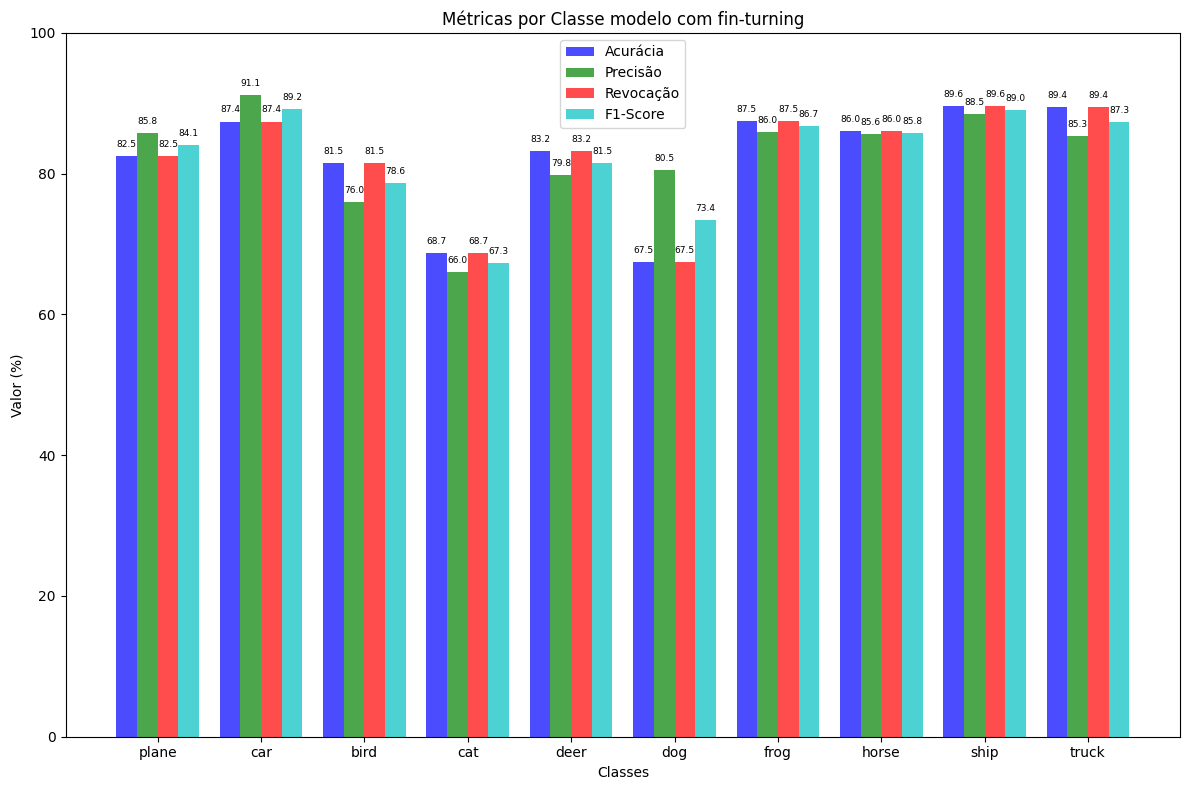

In [26]:
def metricas_modelo(modelo, titulo_grafico):
  # Prepara contador de previsões para cada classe
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  false_pred = {classname: 0 for classname in classes}  # Contador de falsos positivos

  with torch.no_grad():  # Desativa o cálculo de gradientes durante a avaliação
      for images, labels in testloader:
          outputs = modelo(images)
          _, predictions = torch.max(outputs, 1)

          # Coletar as previsões corretas para cada classe
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

              # Contabiliza falsos positivos
              if label != prediction:
                  false_pred[classes[prediction]] += 1

  # Inicializa listas para armazenar métricas
  accuracies = []
  precisions = []
  recalls = []
  f1_scores = []
  class_names = []

  # Cálculo das métricas e armazenamento para o gráfico
  for classname in classes:
      correct_count = correct_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      precision = 100 * float(correct_count) / (correct_count + false_pred[classname]) if (correct_count + false_pred[classname]) > 0 else 0
      recall = 100 * float(correct_count) / (total_pred[classname]) if total_pred[classname] > 0 else 0
      f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

      accuracies.append(accuracy)
      precisions.append(precision)
      recalls.append(recall)
      f1_scores.append(f1_score)
      class_names.append(classname)

  # Criar gráfico de barras agrupadas
  n_classes = len(classes)
  x = np.arange(n_classes)  # Índices das classes
  width = 0.2  # Largura das barras

  plt.figure(figsize=(12, 8))

  # Adiciona as barras para cada métrica
  bars1 = plt.bar(x - 1.5 * width, accuracies, width, label='Acurácia', color='b', alpha=0.7)
  bars2 = plt.bar(x - 0.5 * width, precisions, width, label='Precisão', color='g', alpha=0.7)
  bars3 = plt.bar(x + 0.5 * width, recalls, width, label='Revocação', color='r', alpha=0.7)
  bars4 = plt.bar(x + 1.5 * width, f1_scores, width, label='F1-Score', color='c', alpha=0.7)

  # Adiciona os números acima das barras
  for bars in [bars1, bars2, bars3, bars4]:
      for bar in bars:
          yval = bar.get_height()
          plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}', ha='center', va='bottom', fontsize=6.5)

  # Configurações dos eixos
  plt.xticks(x, class_names)
  plt.ylim(0, 100)
  plt.title('Métricas por Classe ' + titulo_grafico)
  plt.xlabel('Classes')
  plt.ylabel('Valor (%)')

  # Adiciona a legenda
  plt.legend()

  # Mostra o gráfico
  plt.tight_layout()
  plt.show()


metricas_modelo(model_zero, 'modelo do zero')
metricas_modelo(model_no_ft, 'modelo sem fine-turning')
metricas_modelo(model_on_ft, 'modelo com fin-turning')

# plotagem train losses da rede do zero

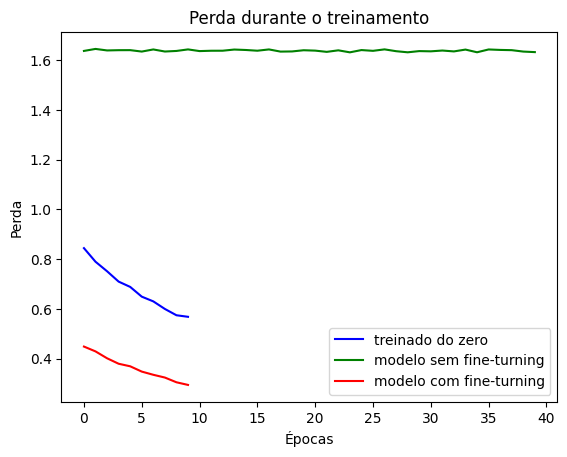

In [27]:
plt.plot(train_losses_zero, color='blue', label='treinado do zero')
plt.plot(train_losses_no_ft, color='green', label='modelo sem fine-turning')
plt.plot(train_losses_on_ft, color='red', label='modelo com fine-turning')
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()